In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:

file_prefix = '2-'

# Load INS data
ins_data = pandas.read_csv('csv/'+file_prefix+'vectornav-ins.csv')
ins_data = ins_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
ins_data['time'] = pandas.to_datetime(ins_data['time'])
ins_data['time'] = (ins_data['time'] - ins_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
ins_data = ins_data.set_index('time')

# Load GPS Fix (raw) data
fix_data = pandas.read_csv('csv/'+file_prefix+'vectornav-fix.csv')
fix_data = fix_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
fix_data['time'] = pandas.to_datetime(fix_data['time'])
fix_data['time'] = (fix_data['time'] - fix_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
fix_data = fix_data.set_index('time')



# Load IMU Data
imu_data = pandas.read_csv('csv/'+file_prefix+'vectornav-imu.csv') 
imu_data = imu_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
imu_data['time'] = pandas.to_datetime(imu_data['time'])
imu_data['time'] = (imu_data['time'] - imu_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
imu_data = imu_data.set_index('time')


# Load Pacmod Speed Data
# pacmod parsed_txt/vehicle_speed is gets corrupt rows, so we will use as_tx/vehicle_speed
pacmod_speed = pandas.read_csv('csv/'+file_prefix+'pacmod-as_tx-vehicle_speed.csv')
pacmod_speed['time'] = pandas.to_datetime(pacmod_speed['time'])
pacmod_speed['time'] = (pacmod_speed['time'] - pacmod_speed['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
# Additionally, there is an factor offset between parsed_txt/vehicle_speed and as_tx/vehicle_speed for whatever reason
# Use 2.237
pacmod_speed['.data'] = pacmod_speed['.data']*2.237
pacmod_speed = pacmod_speed.set_index('time')

# Load Pacmod Steer Data
pacmod_steer = pandas.read_csv('csv/'+file_prefix+'pacmod-parsed_tx-steer_rpt.csv')
pacmod_steer = pacmod_steer.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
pacmod_steer['time'] = pandas.to_datetime(pacmod_steer['time'])
pacmod_steer['time'] = (pacmod_steer['time'] - pacmod_steer['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
pacmod_steer = pacmod_steer.set_index('time')

In [3]:
import scipy.integrate as integrate

vx = 0.0
vy = 0.0

theta = 0
imu_data['x_pos'] = 0.0
imu_data['y_pos'] = 0.0
imu_data['theta'] = 0.0

x_pos_prev = 0.0
x_vel_prev = 0.0
y_pos_prev = 0.0
y_vel_prev = 0.0
theta_prev = 0.0
time_prev  = 0.0

for index, row in imu_data.iterrows():
    dt = index - time_prev
    imu_data.at[index, 'theta'] = theta_prev + dt * imu_data.at[index,'.Gyro.z']
    imu_data.at[index, 'theta'] = math.atan2(math.sin(imu_data.at[index, 'theta']), math.cos(imu_data.at[index, 'theta']))
    imu_data.at[index, 'x_pos'] = x_pos_prev + dt * vx + 1/2 * imu_data.at[index,'.Accel.x'] * dt**2
    imu_data.at[index, 'y_pos'] = y_pos_prev + dt * vy + 1/2 * imu_data.at[index,'.Accel.y'] * dt**2
    vx += imu_data.at[index,'.Accel.x'] * dt
    vy += imu_data.at[index,'.Accel.y'] * dt
    x_pos_prev = imu_data.at[index, 'x_pos']
    y_pos_prev = imu_data.at[index, 'y_pos']
    theta_prev = imu_data.at[index, 'theta']
    time_prev = index
imu_data

,.header.seq,.header.frame_id,.gps_time,.Mag.x,.Mag.y,.Mag.z,.Accel.x,.Accel.y,.Accel.z,.Gyro.x,.Gyro.y,.Gyro.z,.Temp,.Pressure,x_pos,y_pos,theta
time,,,,,,,,,,,,,,,,,
0.000000,13361,vectornav,1.266945e+09,0.0,0.0,0.0,-0.522194,-0.369159,-9.998274,-0.018315,0.001394,-0.001137,0.0,0.0,0.000000,0.000000,0.000000
0.019960,13362,vectornav,1.266945e+09,0.0,0.0,0.0,-0.388047,-0.405782,-9.588663,0.007059,-0.003691,0.000743,0.0,0.0,-0.000077,-0.000081,0.000015
0.040099,13363,vectornav,1.266945e+09,0.0,0.0,0.0,-0.391195,-0.274625,-9.622240,-0.024199,0.003544,0.000920,0.0,0.0,-0.000313,-0.000300,0.000033
0.059968,13364,vectornav,1.266945e+09,0.0,0.0,0.0,-0.408275,-0.300097,-10.086546,-0.015502,0.002079,0.001560,0.0,0.0,-0.000704,-0.000630,0.000064
0.079919,13365,vectornav,1.266945e+09,0.0,0.0,0.0,-0.472643,-0.085636,-9.763033,0.008683,0.000771,0.001319,0.0,0.0,-0.001271,-0.001038,0.000091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724.632229,49595,vectornav,1.266946e+09,0.0,0.0,0.0,-0.183921,0.276102,-9.765024,-0.000359,0.000097,0.000180,0.0,0.0,-32677.258976,-17662.194621,-3.103838
724.652301,49596,vectornav,1.266946e+09,0.0,0.0,0.0,-0.203688,0.272100,-9.789581,-0.000758,0.001052,-0.000341,0.0,0.0,-32679.196202,-17662.557942,-3.103845
724.672301,49597,vectornav,1.266946e+09,0.0,0.0,0.0,-0.165560,0.298277,-9.784327,0.001301,-0.001483,0.000985,0.0,0.0,-32681.126553,-17662.919846,-3.103826


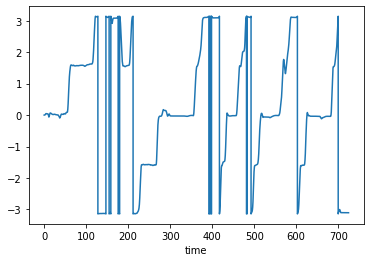

In [4]:
imu_data['theta'].plot();

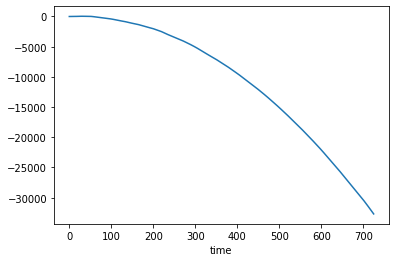

In [5]:
imu_data['x_pos'].plot();